In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

# WILD WITH FATHER

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_with_father'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [6]:
def load_subject(subject):
    if subject == 'W8Fam':
        df_mouse = pd.read_csv(data_directory + subject + '/cells300.csv')  
    else:
        df_mouse = pd.read_csv(data_directory + subject + '/cells2500.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

In [7]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
dict_results_across_mice = np.load('dict_results/dict_results_across_mice_WILD_with_father2500.npy', 
                                   allow_pickle=True).item()

In [9]:
dict_results_across_mice.keys()

dict_keys(['W10Control', 'W14Fam', 'W27Unfam', 'W16Fam', 'W38Control', 'W25Fam', 'W26Control', 'W20Unfam', 'W15Control', 'W2Unfam', 'W31Control', 'W11Unfam', 'W5Fam', 'W23Control', 'W13Unfam', 'W18Unfam', 'W7Control', 'W40Fam', 'W29Control', 'W3Control', 'W36Fam', 'W8Fam', 'W17Control', 'W34Fam'])

In [10]:
# remove unclean data
dict_results_across_mice.pop('W8Fam')
subjects.remove('W8Fam')

In [11]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


In [12]:
experimental_groups

{'Control': ['W10Control',
  'W38Control',
  'W26Control',
  'W15Control',
  'W31Control',
  'W23Control',
  'W7Control',
  'W29Control',
  'W3Control',
  'W17Control'],
 'Unfam': ['W27Unfam',
  'W20Unfam',
  'W2Unfam',
  'W11Unfam',
  'W13Unfam',
  'W18Unfam'],
 'Fam': ['W14Fam', 'W16Fam', 'W25Fam', 'W5Fam', 'W40Fam', 'W36Fam', 'W34Fam']}

## Calculate number of cells

In [13]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [14]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count])
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.800493,0.30763,0.314441
1,Primary motor area,0.317994,0.858661,0.63766
2,Secondary motor area,0.341591,0.341483,0.835318
3,Primary somatosensory area,0.635184,0.475303,0.29274
4,Supplemental somatosensory area,0.492843,0.186436,0.496859
...,...,...,...,...
194,Interfascicular nucleus raphe,0.554434,0.271766,0.14589
195,Interpeduncular nucleus,0.747276,0.456427,0.320072
196,Rostral linear nucleus raphe,0.518105,0.546471,0.320655
197,Central linear nucleus raphe,0.80283,0.29997,0.20783


In [15]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [16]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:0].set_index('area')

,pval_Control_vs_Fam
area,


In [17]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Posterior amygdalar nucleus,7.49994e-06
Medial amygdalar nucleus,0.000958334
Cortical amygdalar area,0.00102667
Claustrum,0.00239708
Piriform area,0.00486937
Postpiriform transition area,0.00750764
Basolateral amygdalar nucleus,0.0080129
Ventral premammillary nucleus,0.00919145
Piriform-amygdalar area,0.0150013


In [18]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Ammon's horn,0.0163953
Anterior olfactory nucleus,0.0217002
Agranular insular area,0.0301669
Substantia nigra compact part,0.0325094
Claustrum,0.0368114
Medial amygdalar nucleus,0.037621
Piriform area,0.0596124
Subiculum,0.0619873
Posterior amygdalar nucleus,0.0829385


## Calculate corr matrices on number of cells

In [19]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

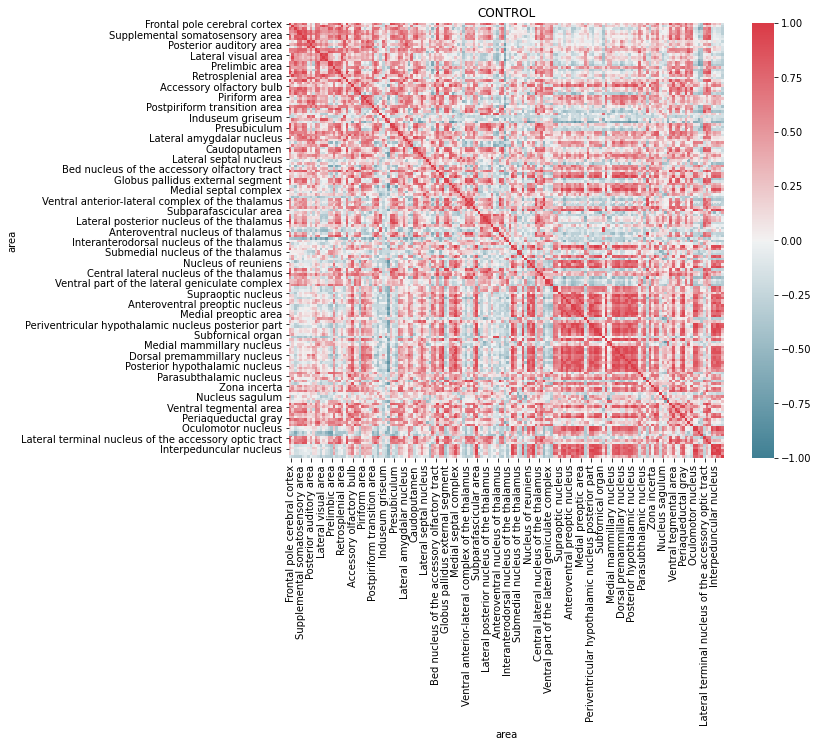

In [20]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

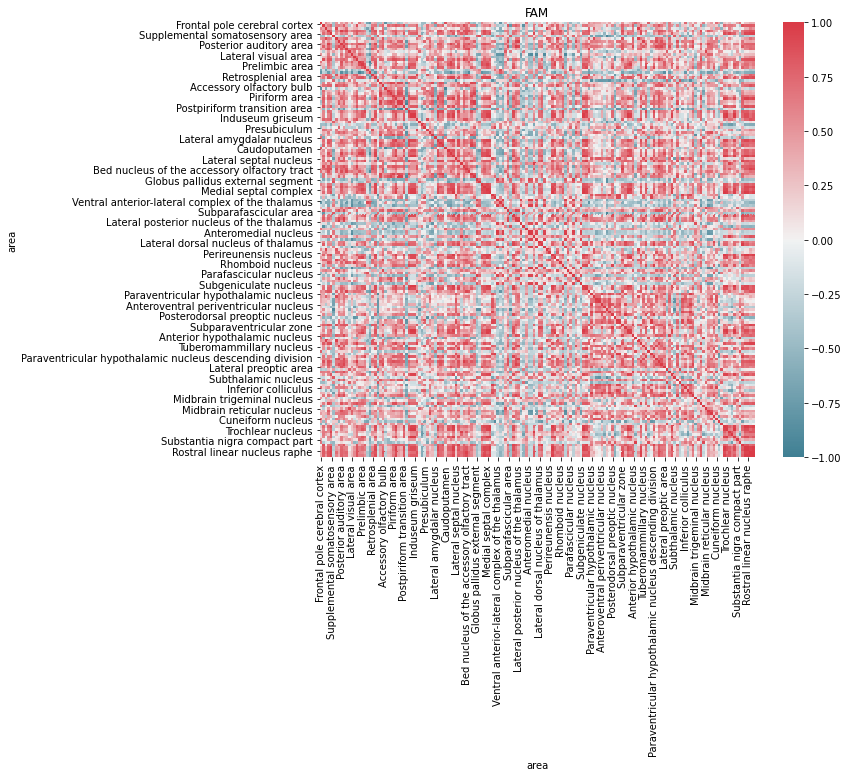

In [21]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

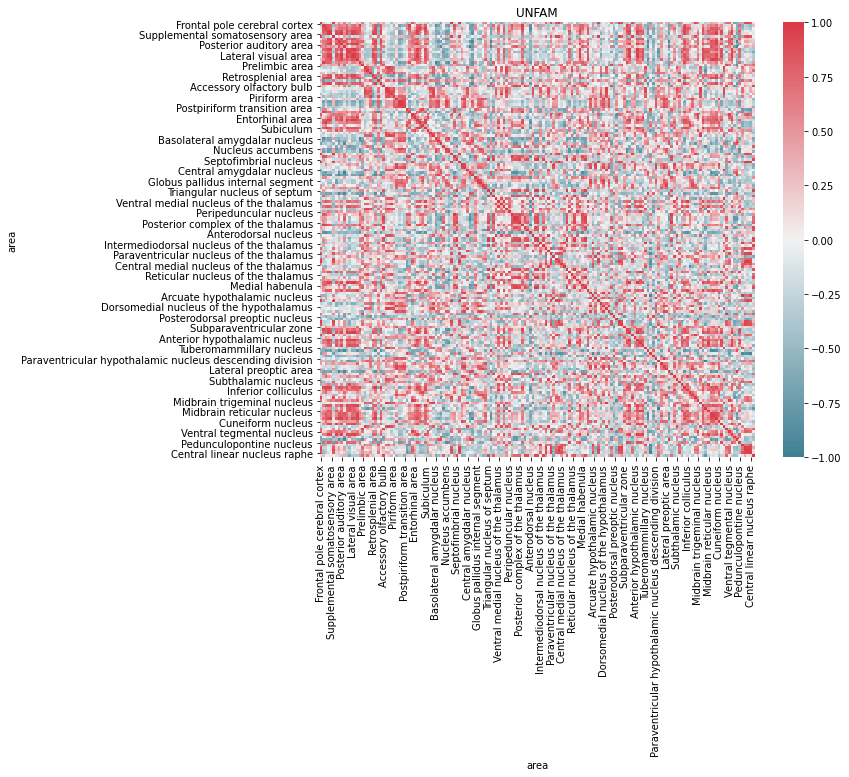

In [22]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

In [23]:
df_control_rd, df_fam_rd, df_unfam_rd = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='relative_density')
df_ttest_rd = ace.test_across_groups([df_control_rd,df_fam_rd,df_unfam_rd])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_rd = df_ttest_rd.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [24]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_rd.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,6.67339e-05
Septofimbrial nucleus,0.00370505
Cortical amygdalar area,0.0181365
Medial amygdalar nucleus,0.0296636
Central amygdalar nucleus,0.0354569
Dentate gyrus,0.0410521
Paraventricular hypothalamic nucleus descending division,0.0567476
Triangular nucleus of septum,0.0667684
Intercalated amygdalar nucleus,0.0763362


In [25]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_rd.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Posterior amygdalar nucleus,0.000687454
Claustrum,0.00270762
Cortical amygdalar area,0.00280396
Medial amygdalar nucleus,0.00649567
Piriform area,0.00703503
Postpiriform transition area,0.0221521
Piriform-amygdalar area,0.0331102
Ventral premammillary nucleus,0.050974
Anterior olfactory nucleus,0.0579301


# WILD without father

In [26]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_without_father'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [27]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [28]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy', allow_pickle=True).item()

In [30]:
# remove unclean data
dict_results_across_mice.pop('W12Fam')
subjects.remove('W12Fam')

In [31]:
dict_results_across_mice.keys()

dict_keys(['W10Control', 'W6Unfam', 'W38Control', 'W26Control', 'W9Fam', 'W15Control', 'W31Control', 'W30Fam', 'W24Unfam', 'W23Control', 'W7Control', 'W35Unfam', 'W4Unfam', 'W32Fam', 'W1Fam', 'W29Control', 'W3Control', 'W28Unfam', 'W39Unfam', 'W22Fam', 'W17Control', 'W37Unfam'])

In [32]:
dict_results_across_mice['W10Control'].keys()


Index(['area', 'n_cells', 'energy', 'density', 'relative_density'], dtype='object')

In [33]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


In [34]:
experimental_groups

{'Control': ['W10Control',
  'W38Control',
  'W26Control',
  'W15Control',
  'W31Control',
  'W23Control',
  'W7Control',
  'W29Control',
  'W3Control',
  'W17Control'],
 'Unfam': ['W6Unfam',
  'W24Unfam',
  'W35Unfam',
  'W4Unfam',
  'W28Unfam',
  'W39Unfam',
  'W37Unfam'],
 'Fam': ['W9Fam', 'W30Fam', 'W32Fam', 'W1Fam', 'W22Fam']}

# Calculate number of cells

In [35]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [36]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count])

In [37]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [38]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Primary motor area,0.000136941
Tuberal nucleus,0.00278097
Main olfactory bulb,0.00603224
Cortical amygdalar area,0.00612165
Posterior amygdalar nucleus,0.00617066
Piriform-amygdalar area,0.0078485
Medial amygdalar nucleus,0.0114026
Postpiriform transition area,0.0143509
Entorhinal area,0.0144108


In [39]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Postpiriform transition area,0.002876
Piriform-amygdalar area,0.00529751
Main olfactory bulb,0.00884306
Piriform area,0.0132735
Cortical amygdalar area,0.0160812
Secondary motor area,0.0171462
Agranular insular area,0.027403
Basolateral amygdalar nucleus,0.0303681
Primary motor area,0.0321418


In [40]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Dorsomedial nucleus of the hypothalamus,0.0165989
Ventral tegmental nucleus,0.0267282
Posterior limiting nucleus of the thalamus,0.0297425
Intergeniculate leaflet of the lateral geniculate complex,0.0394482
Tuberal nucleus,0.0407472
Dorsal nucleus raphe,0.0421134
Medial amygdalar nucleus,0.0492919
Subgeniculate nucleus,0.0683345
Lateral preoptic area,0.0760859


# Calculate corr matrices on number of cells

In [41]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

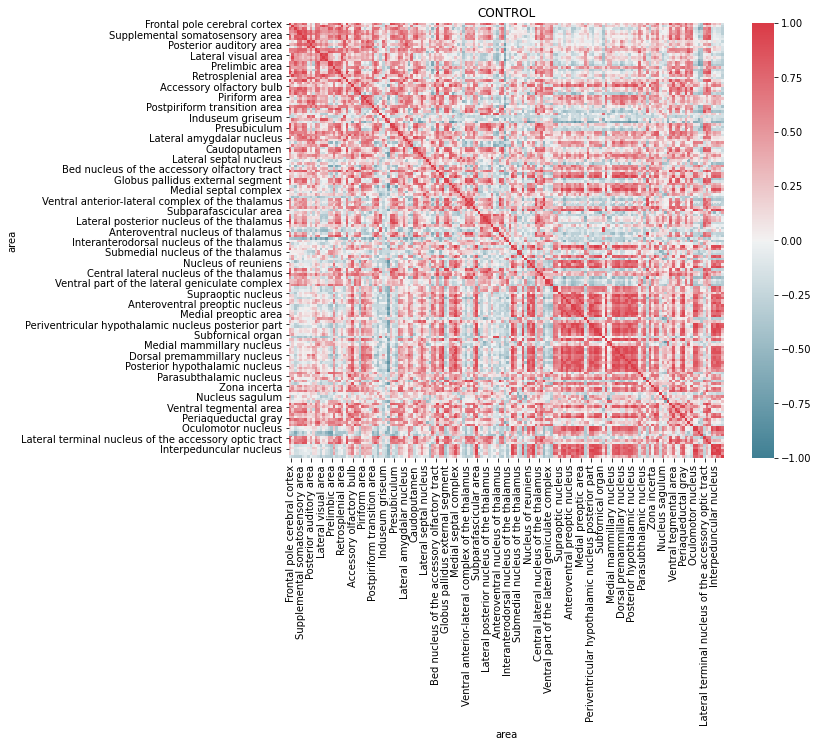

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

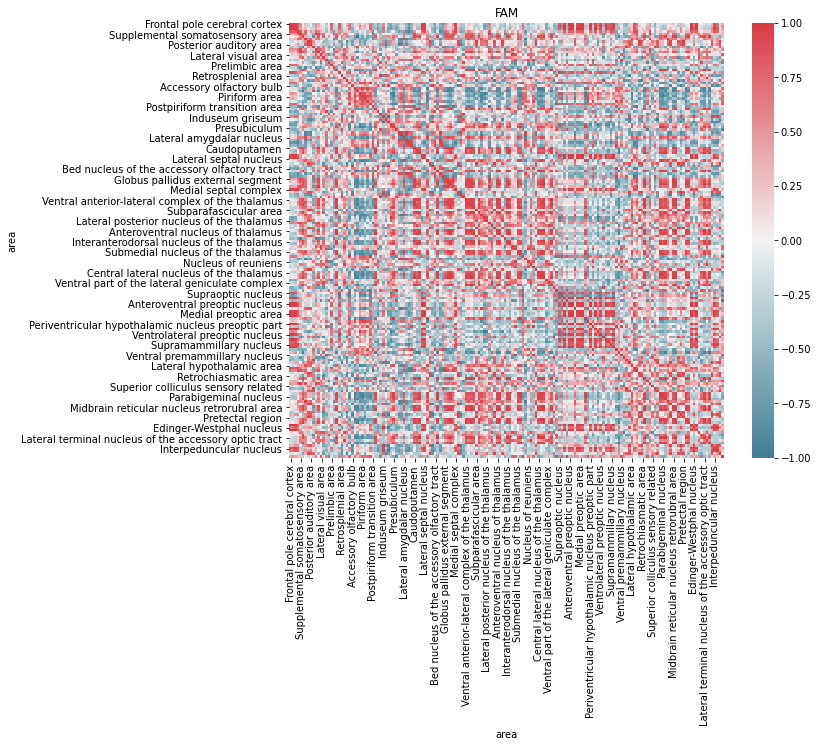

In [43]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

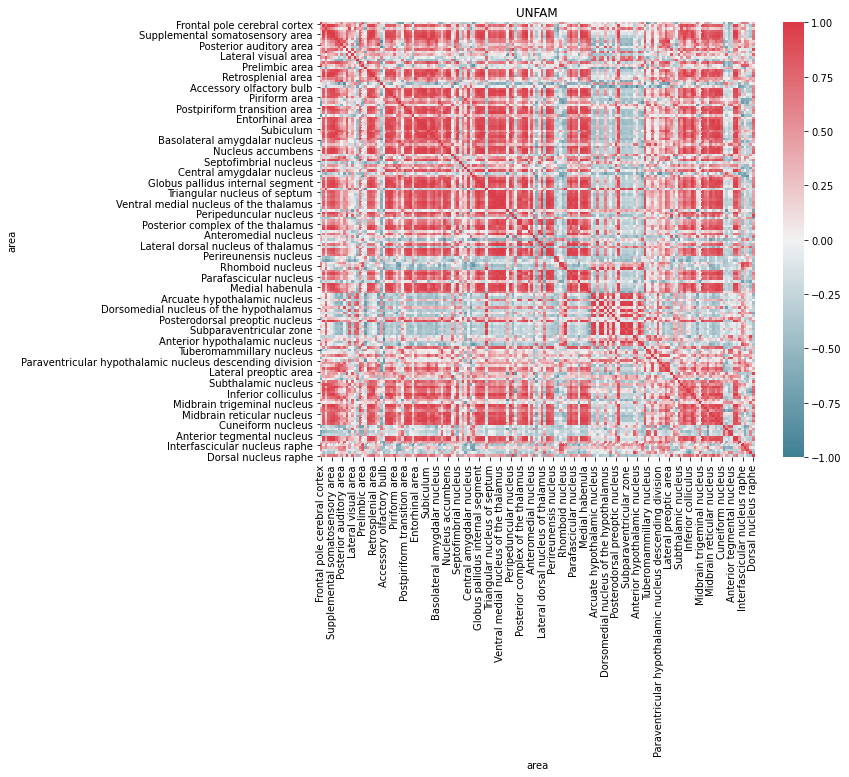

In [44]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

In [45]:
dict_results_across_mice['W10Control']

,area,n_cells,energy,density,relative_density
0,Frontal pole cerebral cortex,8,109399.515947,14.664814,0.618239
1,Primary motor area,59,82601.946770,9.965208,0.420113
2,Secondary motor area,121,138500.040750,17.695219,0.745995
3,Primary somatosensory area,169,105653.441695,13.502742,0.569248
4,Supplemental somatosensory area,44,70555.619944,9.324905,0.393119
...,...,...,...,...,...
194,Interfascicular nucleus raphe,0,0.000000,0.000000,0.000000
195,Interpeduncular nucleus,3,64960.745032,7.796849,0.328699
196,Rostral linear nucleus raphe,0,0.000000,0.000000,0.000000
197,Central linear nucleus raphe,0,0.000000,0.000000,0.000000
